In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

In [8]:
def train_xgboost_model(X_train,y_train,X_test,y_test):
    
    
    # Thiết lập tham số cho Grid Search
    param_grid = {
        'n_estimators': [10, 50, 100],
        'learning_rate': [0.01, 0.05, 0.07],
        'max_depth': [3, 5, 7, 10],
        'subsample': [0.8, 1],
    }
    
    # Khởi tạo XGBRegressor với GPU
    xgb_model = XGBRegressor( eval_metric='rmse', gpu_id=1)
    
    # Thiết lập GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        cv=3,  # Sử dụng 3-fold cross-validation
        scoring='neg_mean_squared_error',  # Đánh giá theo MSE
        verbose=1,
        # n_jobs=-1  # Sử dụng tất cả các nhân CPU để tăng tốc
    )
    
    # Tìm kiếm mô hình tốt nhất
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # In ra tham số tốt nhất
    print("Best parameters found: ", grid_search.best_params_)
    

    # Dự đoán trên tập kiểm tra
    y_pred = best_model.predict(X_test)
    y_train_pred = best_model.predict(X_train)
    
    # Tính chỉ số trên tập train
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    # Tính chỉ số trên tập test
    mse_test = mean_squared_error(y_test, y_pred)
    rmse_test = mean_squared_error(y_test, y_pred, squared=False)
    mae_test = mean_absolute_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)

    # Kết quả trên tập train
    print("Training Set Metrics:")
    print(f'MSE: {mse_train:.2f}')
    print(f'RMSE: {rmse_train:.2f}')
    print(f'MAE: {mae_train:.2f}')
    print(f'R-squared (R²): {r2_train:.2f}')

    # Kết quả trên tập test
    print("\nTest Set Metrics:")
    print(f'MSE: {mse_test:.2f}')
    print(f'RMSE: {rmse_test:.2f}')
    print(f'MAE: {mae_test:.2f}')
    print(f'R-squared (R²): {r2_test:.2f}')


    # Trả về mô hình tốt nhất và các kết quả dự đoán
    return grid_search.best_estimator_, y_test, y_pred




In [11]:
df = pd.read_csv(r'../data_model/ACB.csv')
df.columns
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
for i in range(1, 61):
    df['ACB_lag_{}'.format(i)] = df['ACB'].shift(i)
df.dropna(inplace=True)
df
df_train = df[:750]
df_test = df[750:]


In [12]:
# Ví dụ sử dụng hàm
model,y_test, y_pred = train_xgboost_model(df_train.drop(columns="ACB"),df_train['ACB'],df_test.drop(columns="ACB"),df_test['ACB'])
# Tạo DataFrame từ dữ liệu thực và dự đoán
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred
})

Fitting 3 folds for each of 72 candidates, totalling 216 fits


c:\Users\dntth\anaconda3\envs\py310\lib\site-packages\xgboost\core.py:158: UserWarning: [03:20:10] WARNING: D:\bld\xgboost-split_1733179550881\work\src\common\error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
c:\Users\dntth\anaconda3\envs\py310\lib\site-packages\xgboost\core.py:158: UserWarning: [03:20:10] WARNING: D:\bld\xgboost-split_1733179550881\work\src\context.cc:52: Only 1 GPUs are visible, setting device ordinal to 0
  warnings.warn(smsg, UserWarning)
c:\Users\dntth\anaconda3\envs\py310\lib\site-packages\xgboost\core.py:158: UserWarning: [03:20:10] WARNING: D:\bld\xgboost-split_1733179550881\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in

Best parameters found:  {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Training Set Metrics:
MSE: 290021.41
RMSE: 538.54
MAE: 366.39
R-squared (R²): 0.96

Test Set Metrics:
MSE: 1120002.86
RMSE: 1058.30
MAE: 870.72
R-squared (R²): 0.52


c:\Users\dntth\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\dntth\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


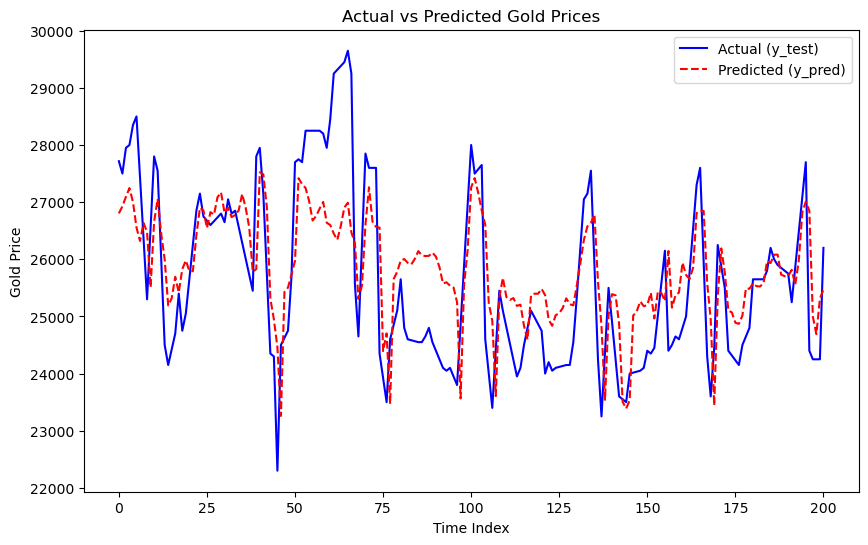

In [15]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 6))

# Trục thời gian
x_axis = np.arange(len(y_test))

# Vẽ giá trị thực (y_test)
plt.plot(x_axis, y_test, label="Actual (y_test)", color='blue')

# Vẽ giá trị dự đoán (y_pred)
plt.plot(x_axis, y_pred, label="Predicted (y_pred)", color='red', linestyle='--')

# Thêm tiêu đề và nhãn
plt.title('Actual vs Predicted Gold Prices')
plt.xlabel('Time Index')
plt.ylabel('Gold Price')

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()